In [1]:
%matplotlib inline
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  
import numpy as np
from sklearn.cluster import KMeans 
from sklearn_extra.cluster import KMedoids
import tensorflow as tf
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from tensorflow.keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Visualer les datas

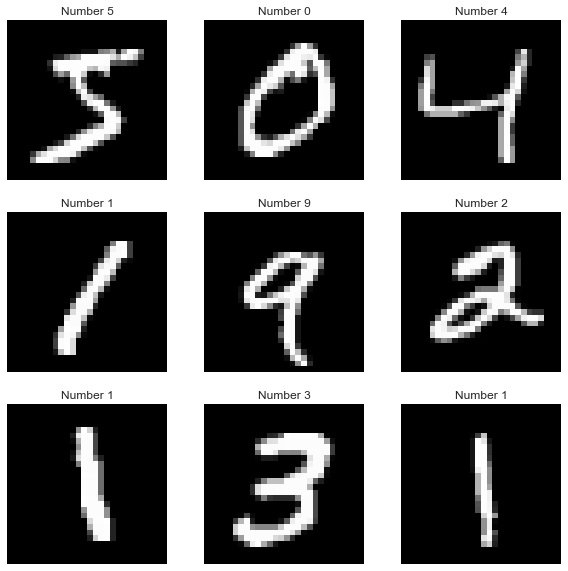

In [3]:
fig, axs = plt.subplots(3, 3, figsize = (10, 10))
plt.gray()
for i, ax in enumerate(axs.flat):
    ax.imshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
plt.show()

In [4]:
#Normaliser les données
training_set = x_train.astype(np.float32) / 255.
test_set = x_test.astype(np.float32) / 255.

#chaque image passe d'un format 28x28 à un format 784x1
training_set = training_set.reshape(len(x_train), -1) 
test_set = test_set.reshape(len(y_test), -1)

# Partie 1: on considère les images indépendantes de leurs labels

## Méthode K-Means

On prend d'abord 10 clusters car il y a 10 classes différentes d'images. 
Le but est d'abord de comprendre comment marche le clustering avec la méthode K-Means.
Nous chercherons ensuite quel est le nombre optimal de clusters à sélectionner.

In [5]:
number_clusters = 10
model = KMeans(n_clusters = number_clusters)
model.fit(training_set)

clusters_predicted = model.predict(training_set) #classe les images dans le cluster dans lequel elles sont le plus proches
centers = model.cluster_centers_

#### L'algorithme K-Means a classé les images dans différents clusters. On écrit alors une fonction pour créer une liste des images pour chaque cluster.

In [6]:
#fonction qui renvoie les positions des images dans le cluster k
def creer_prediction_set(prediction, k):
    prediction_set_k = []
    for i in range(len(prediction)):
        if prediction[i] == k:
            prediction_set_k.append(i)
    return prediction_set_k 

## On peut maintenant visualiser les résultats du clustering de notre algorithme. 

Cluster n° 4
taille cluster: 8847


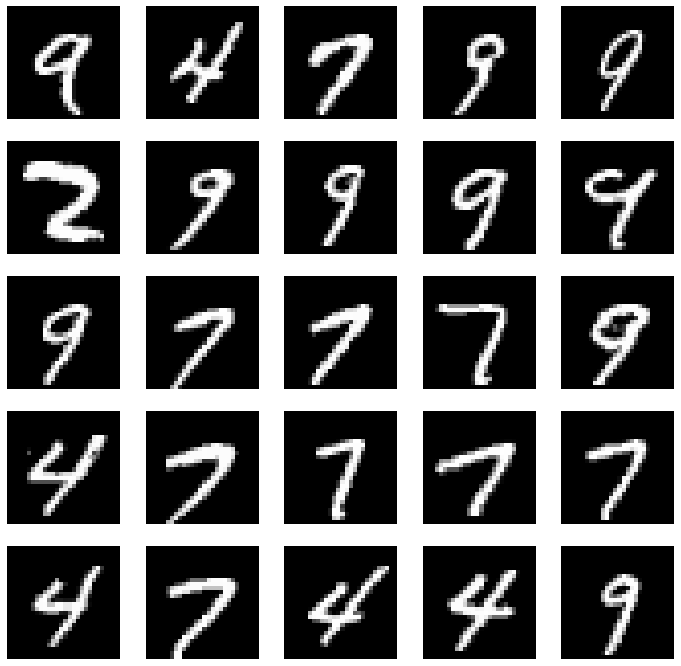


Cluster n° 1
taille cluster: 5611


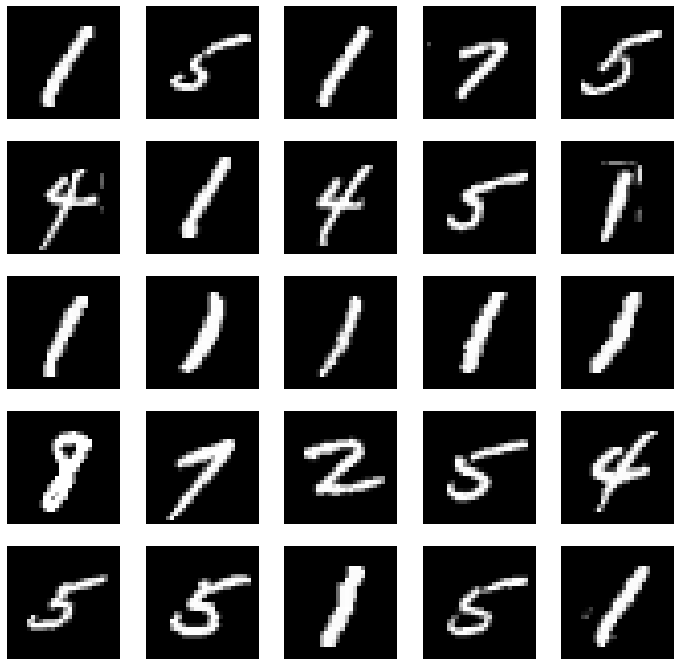

In [8]:
clusters_regardes = np.random.randint(0, number_clusters, 2)
for k in clusters_regardes:
    cluster = creer_prediction_set(clusters_predicted, k)
    print("Cluster n°", k)
    print("taille cluster:", len(cluster))
    fig, axs = plt.subplots(5, 5, figsize = (12, 12))
    plt.gray()
    for i, ax in enumerate(axs.flat):
        ax.imshow(x_train[cluster[i]])
        ax.axis('off')
    plt.show()
    print()

### Est-ce que prendre 10 clusters est la meilleure solution pour notre méthode de clustering? 
#### Itération sur le nombre de clusters pour trouver le nombre de clusters optimal

In [9]:
# on écrit une fonction qui calcule l'entropie moyenne pondérée d'un modèle 
from scipy.stats import entropy
def score_entropy(prediction, num_clusters):
    entropie_moyenne_ponderee = 0
    for k in range(num_clusters):
        cluster = creer_prediction_set(prediction, k)
        entropy_cluster = entropy(cluster)
        entropie_moyenne_ponderee += len(cluster)*entropy_cluster
    entropie_moyenne_ponderee /= len(prediction)
    return entropie_moyenne_ponderee   

In [10]:
inertia=[]
silhouettes=[]
calinksi=[]
entropie = []
times = []

for k in range(2, 80):
    start = time.time()
    model_loop = KMeans(n_clusters = k).fit(training_set)
    end = time.time()
    times.append(end-start)
    
    inertia.append(model_loop.inertia_)
    
    silhouette_avg = silhouette_score(training_set, model_loop.fit_predict(training_set))
    silhouettes.append(silhouette_avg)
    
    calinski_k = calinski_harabasz_score(training_set, model_loop.labels_)
    calinksi.append(calinski_k)
    
    entropie_k = score_entropy(model_loop.labels_, k)
    entropie.append(entropie_k)


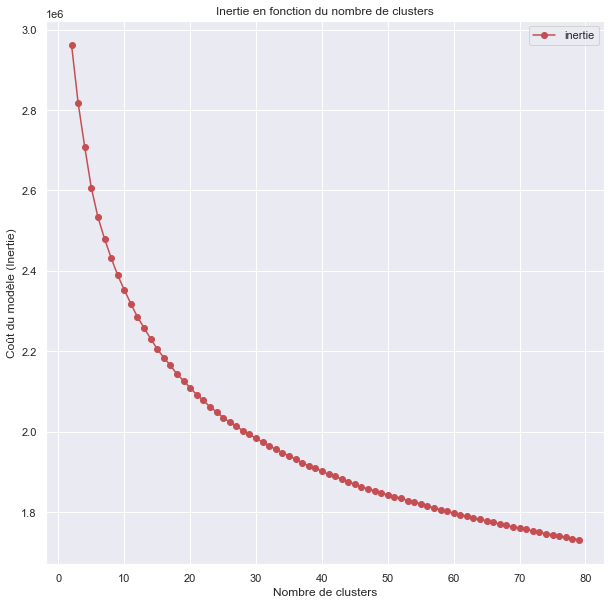

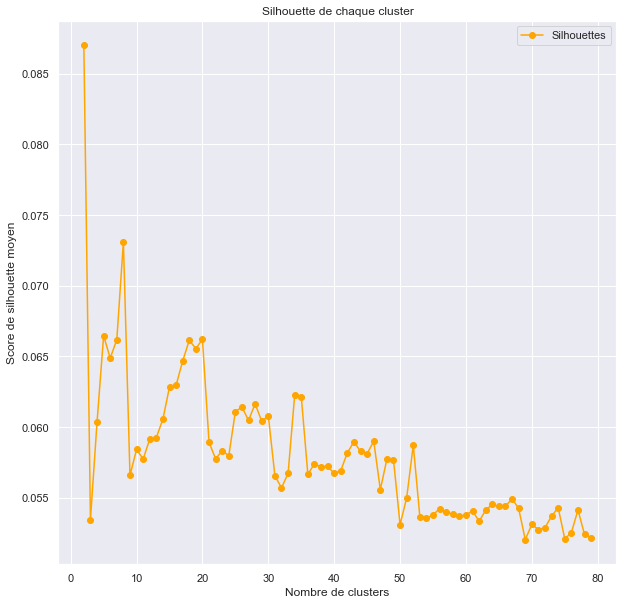

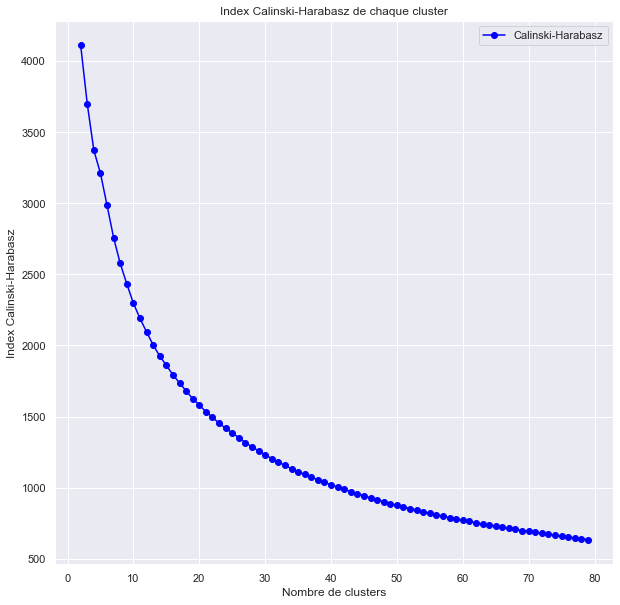

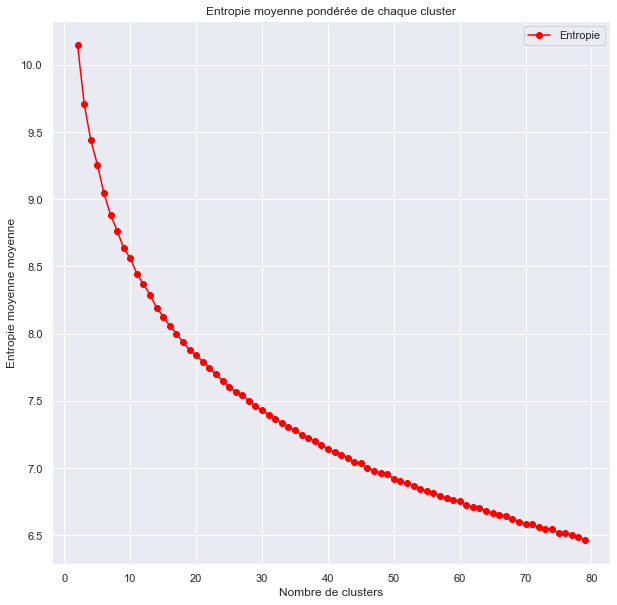

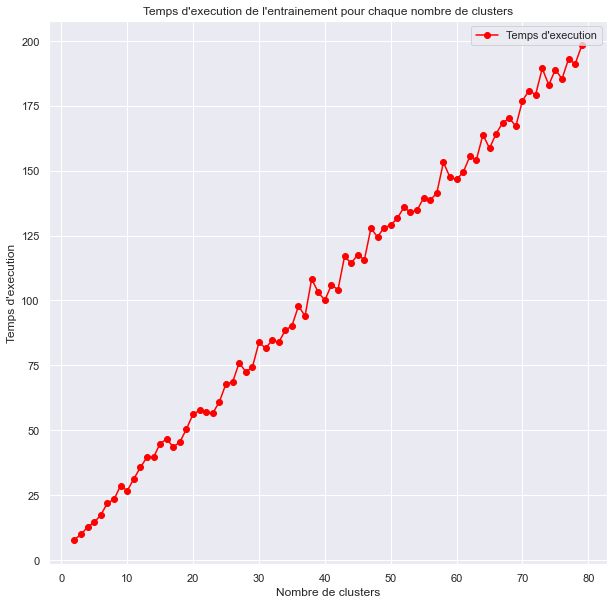

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(range(2, len(inertia)+2), inertia, c = 'r', label = 'inertie', marker='o')
ax.legend(loc='best')
ax.grid('on')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Coût du modèle (Inertie)')
ax.set_title('Inertie en fonction du nombre de clusters')
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(range(2, len(silhouettes)+2), silhouettes, label='Silhouettes', c='orange', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score de silhouette moyen')
ax.grid('on')
ax.set_title('Silhouette de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(range(2, len(calinksi)+2), calinksi, label='Calinski-Harabasz', c='blue', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Index Calinski-Harabasz')
ax.grid('on')
ax.set_title('Index Calinski-Harabasz de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(range(2, len(entropie)+2), entropie, label='Entropie', c='red', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Entropie moyenne moyenne')
ax.grid('on')
ax.set_title('Entropie moyenne pondérée de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(range(2, len(times)+2), times, label="Temps d'execution", c='red', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel("Temps d'execution")
ax.grid('on')
ax.set_title("Temps d'execution de l'entrainement pour chaque nombre de clusters")
plt.show()

In [12]:
#on cherche les maximas des incides autres que la fonction de coût
# on écrit pour cela une fonction qui cherche les 5 maximas d'un tableau, classés par ordre décroissant
def maxs_tab(tab):
    maxi = [0, 0, 0, 0, 0]
    indexes = [0, 0, 0, 0, 0]
    for i in range(len(tab)):
        if tab[i] > maxi[0]:
            maxi[0] = tab[i]
            indexes[0] = i+2 # +2 car le nombre de clusters qu'on calcule commence à 2, pas 0
        elif tab[i] > maxi[1]:
            maxi[1] = tab[i]
            indexes[1] = i+2
        elif tab[i] > maxi[2]:
            maxi[2] = tab[i]
            indexes[2] = i+2
        elif tab[i] > maxi[3]:
            maxi[3] = tab[i]
            indexes[3] = i+2
        elif tab[i] > maxi[4]:
            maxi[4] = tab[i]
            indexes[4] = i+2
    return maxi, indexes

In [13]:
max_sil, indexes_sil = maxs_tab(silhouettes)
max_CH, indexes_CH = maxs_tab(calinksi)
max_en, indexes_en = maxs_tab(entropie)

print("Silhouette")
print(max_sil)
print(indexes_sil)
print()
print("Indice de Calinski-Harabasz")
print(max_CH)
print(indexes_CH)
print()
print("Entropie moyenne pondérée")
print(max_en)
print(indexes_en)

Silhouette
[0.08700923, 0.07311118, 0.066212334, 0.06614556, 0.06556171]
[2, 8, 20, 18, 19]

Indice de Calinski-Harabasz
[4108.178830816642, 3696.564540036035, 3370.5414670469604, 3209.055000597564, 2985.0170827006455]
[2, 3, 4, 5, 6]

Entropie moyenne pondérée
[10.144581776065408, 9.711119849908103, 9.438136338414356, 9.258305151824157, 9.043510080333563]
[2, 3, 4, 5, 6]


### On a trouvé le nombre optimal de clusters. On peut implémenter le modèle K-Means avec ce nombre de clusters.

In [14]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
optimal_n_clusters = 19
with tf.device('/device:GPU:0'): # permet d'exécuter la fonction sur le gpu, ce qui est plus rapide 
                                 # et demande moins de ressources, mais ne change rien au résultat final
    start = time.time()

    optimal_model = KMeans(n_clusters = optimal_n_clusters)
    optimal_model.fit(training_set)

    optimal_prediction = optimal_model.predict(training_set)

    end = time.time()
    print("Durée Kmeans pour", optimal_n_clusters, "clusters:", round((end - start), 2), "s")

Durée Kmeans pour 19 clusters: 47.21 s


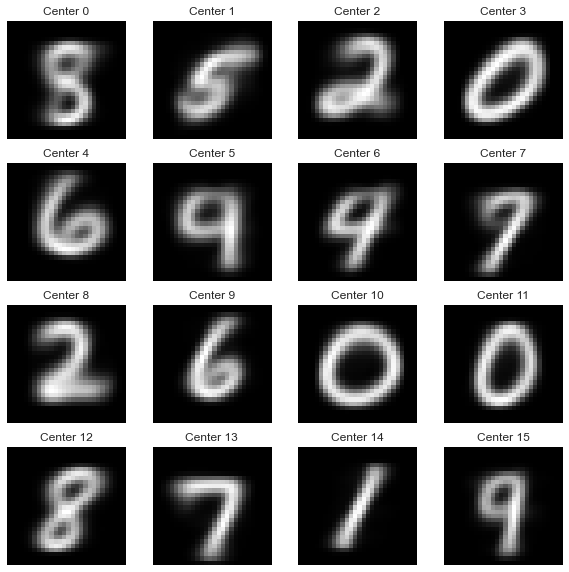

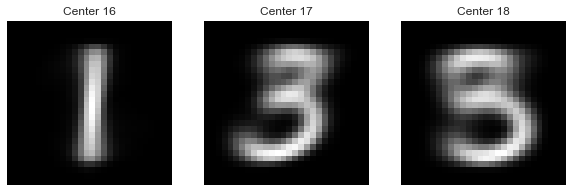

In [15]:
# visualisons les centres de chaque cluster
centroids = optimal_model.cluster_centers_

centers = []
for i in range(len(centroids)):
    centers.append(centroids[i].reshape(28, 28))


fig, axs = plt.subplots(4, 4, figsize = (10, 10))
plt.gray()
for i, ax in enumerate(axs.flat):
    ax.imshow(centers[i])
    ax.axis('off')
    ax.set_title('Center {}'.format(i))
    
fig, ax = plt.subplots(1, 3, figsize = (10, 10))
ax[0].imshow(centers[16])
ax[0].axis('off')
ax[0].set_title('Center {}'.format(16))
ax[1].imshow(centers[17])
ax[1].axis('off')
ax[1].set_title('Center {}'.format(17))
ax[2].imshow(centers[18])
ax[2].axis('off')
ax[2].set_title('Center {}'.format(18))
plt.show()

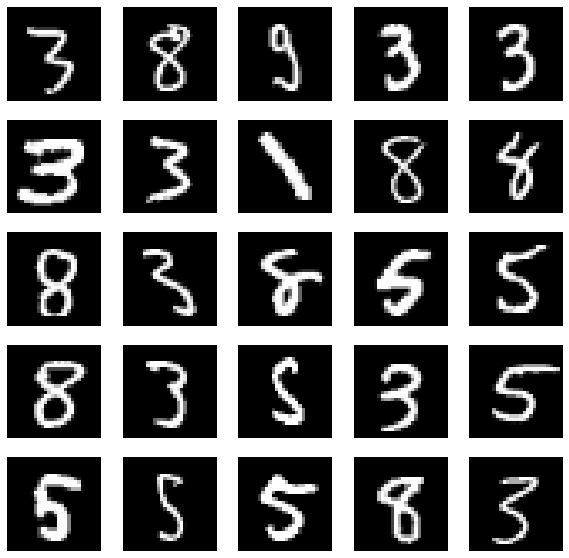

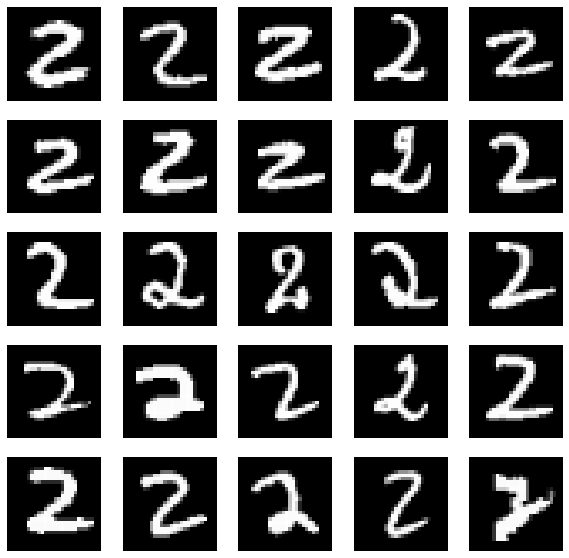

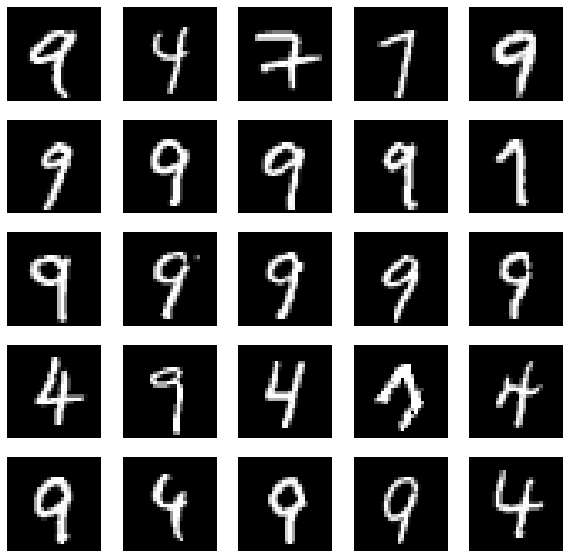

In [16]:
#on peut aussi visualiser les premieres images de certains clusters
#on sélectionne par exemple les clusters 0, 8 et 15
selection = [0, 8, 15]
for k in range(3):
    cluster = creer_prediction_set(optimal_prediction, selection[k])
    fig, axs = plt.subplots(5, 5, figsize = (10, 10))
    plt.gray()
    for i, ax in enumerate(axs.flat):
        ax.imshow(x_train[cluster[i]])
        ax.axis('off')
    plt.show()
    print()

In [17]:
# On peut enfin calculer les valeurs de l'indice CH et de l'entropie moyenne pondérée 

indice_calinski_opt_kmeans = calinski_harabasz_score(training_set, optimal_model.labels_)
entropie_opt_kmeans = score_entropy(optimal_model.labels_, optimal_n_clusters)
print("Indice de Calinski-Harabasz pour", optimal_n_clusters, "clusters:", round(indice_calinski_opt_kmeans, 2))
print("Entropie pour", optimal_n_clusters, "clusters:" , round(entropie_opt_kmeans, 2))

Indice de Calinski-Harabasz pour 19 clusters: 1628.43
Entropie pour 19 clusters: 7.9


## Méthode K-Medoids

###### On met en place le même processus, mais on utilise la méthode K-Medoids et non K-Means.

In [18]:
from sklearn_extra.cluster import KMedoids
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
number_clusters = 19

with tf.device('/device:GPU:0'): 
    start = time.time()

    model = KMedoids(n_clusters = number_clusters)
    model.fit(training_set)

    clusters_predicted = model.predict(training_set) 
    centers = model.cluster_centers_

    end = time.time()
    print("Durée K-Medoids pour", number_clusters, "clusters:", round((end - start), 2), "s")

Durée K-Medoids pour 19 clusters: 109.64 s


Cluster n° 7
taille cluster: 4246


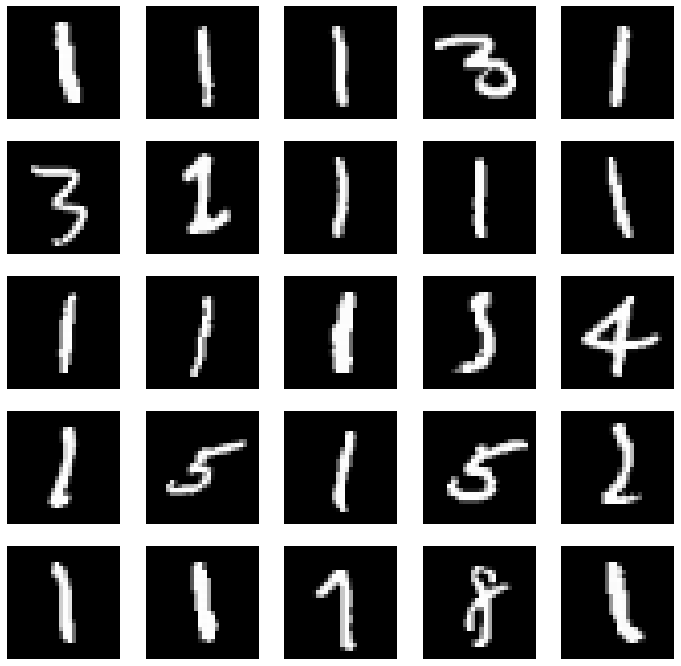


Cluster n° 15
taille cluster: 1654


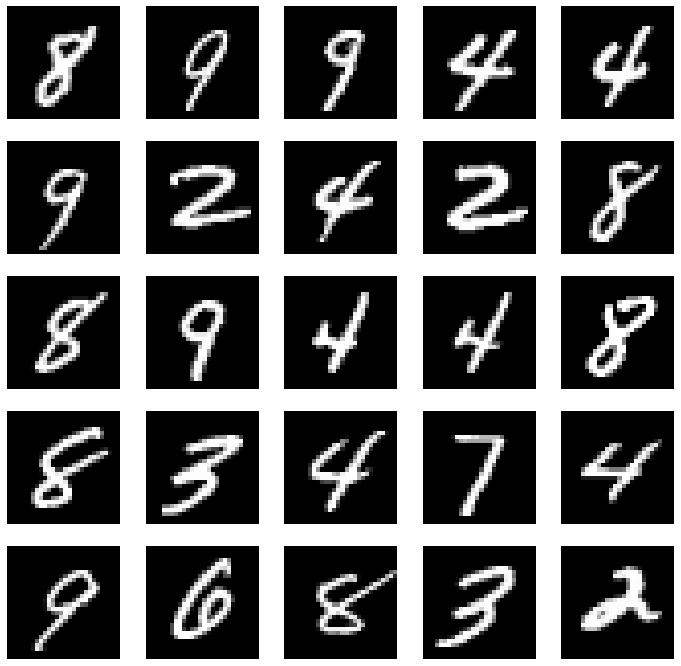

In [19]:
clusters_regardes = np.random.randint(0, number_clusters, 2)
for k in clusters_regardes:
    cluster = creer_prediction_set(clusters_predicted, k)
    print("Cluster n°", k)
    print("taille cluster:", len(cluster))
    fig, axs = plt.subplots(5, 5, figsize = (12, 12))
    plt.gray()
    for i, ax in enumerate(axs.flat):
        ax.imshow(x_train[cluster[i]])
        ax.axis('off')
    plt.show()
    print()

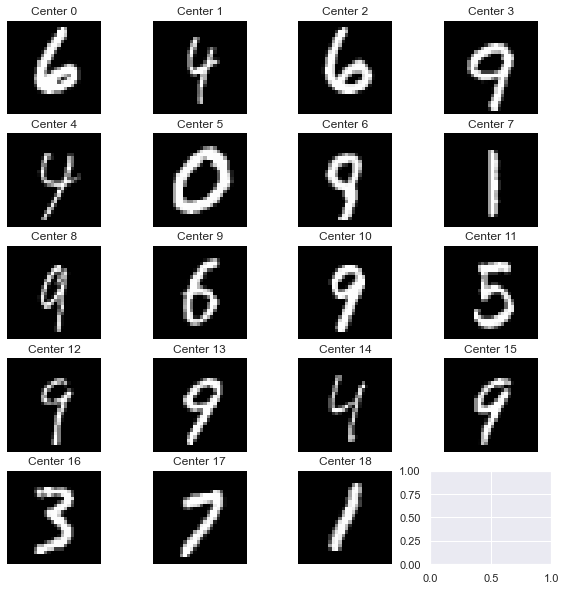

In [20]:
#Visualisation des centres
# visualisons les centres de chaque cluster
centroids_indices = model.medoid_indices_

fig, axs = plt.subplots(5, 4, figsize = (10, 10))
plt.gray()
for i, ax in enumerate(axs.flat):
    if i<19:
        ax.imshow(x_train[centroids_indices[i]])
        ax.axis('off')
        ax.set_title('Center {}'.format(i))
    
plt.show()

In [21]:
indice_calinski = calinski_harabasz_score(training_set, model.labels_)
entropie = score_entropy(model.labels_, number_clusters)
print("Indice de Calinski-Harabasz pour", number_clusters, "clusters:", round(indice_calinski, 2))
print("Entropie pour", number_clusters, "clusters:" , round(entropie, 2))

Indice de Calinski-Harabasz pour 19 clusters: 1135.06
Entropie pour 19 clusters: 7.94


In [22]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import accuracy_score
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

inertia_medoids=[]
homogeneite_medoids=[]
precision_medoids=[]
silhouettes_medoids=[]
times = []
calinski_medoids = []
entropie_medoids = []

with tf.device('/device:GPU:0'):
    for k in range(2, 263, 10):
        start = time.time()
        
        model_loop = KMedoids(n_clusters = k)
        model_loop.fit(training_set)
        
        end = time.time()
        times.append(end-start)
        
        inertia_medoids.append(model_loop.inertia_)

        homogen_loop = homogeneity_score(y_train, model_loop.labels_)
        homogeneite_medoids.append(homogen_loop)

        nb_erreurs_loop = erreurs_totales(model_loop.labels_, k)
        pourcentage_erreur_loop = nb_erreurs_loop/len(training_set)
        precision_k = 1-pourcentage_erreur_loop
        precision_medoids.append(precision_k)

        cluster_labels_pour_sil = model_loop.predict(training_set)
        silhouette_avg = silhouette_score(training_set, cluster_labels_pour_sil)
        silhouettes_medoids.append(silhouette_avg)

        calinski_k = calinski_harabasz_score(training_set, model_loop.labels_)
        calinski_medoids.append(calinski_k)

        entropie_k = score_entropy(model_loop.labels_, k)
        entropie_medoids.append(entropie_k)

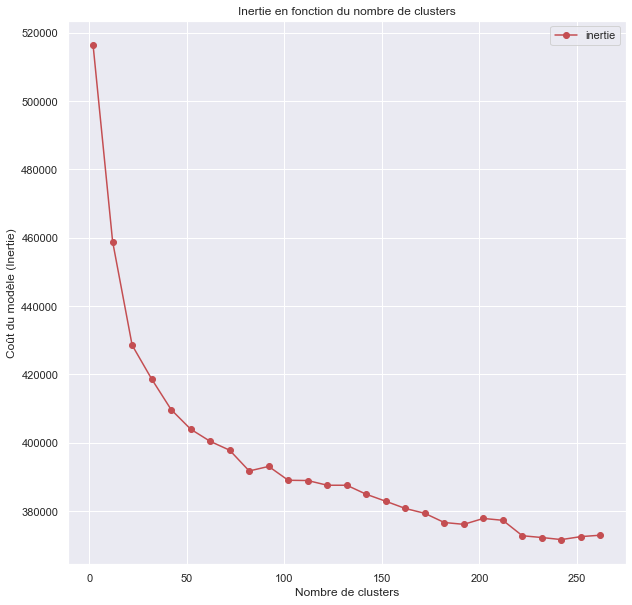

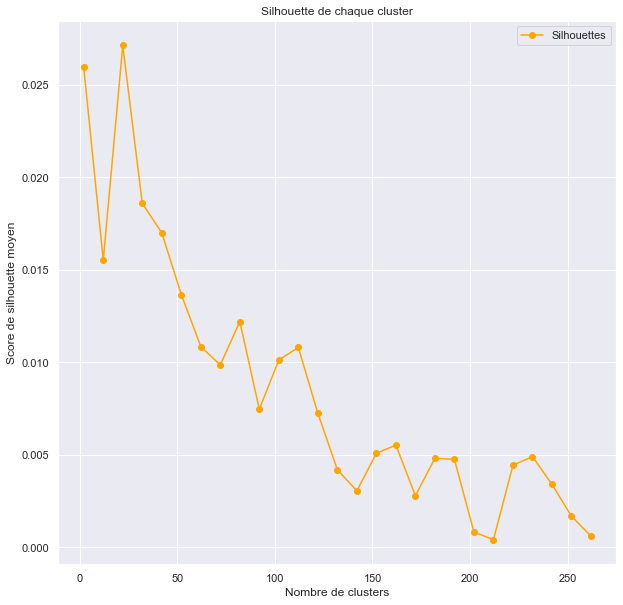

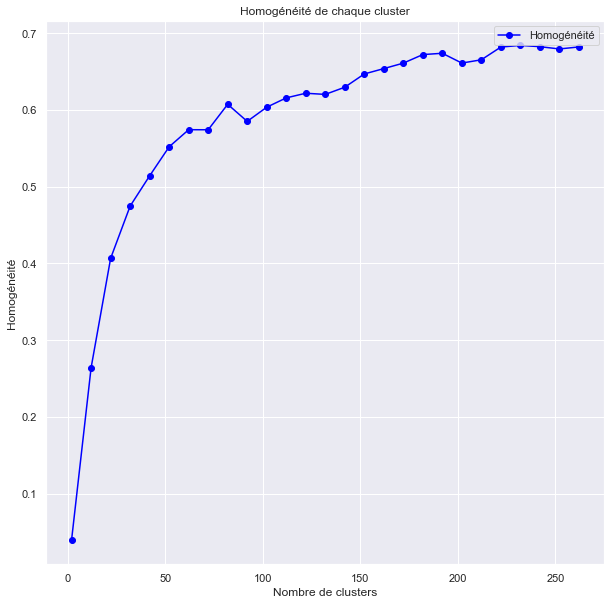

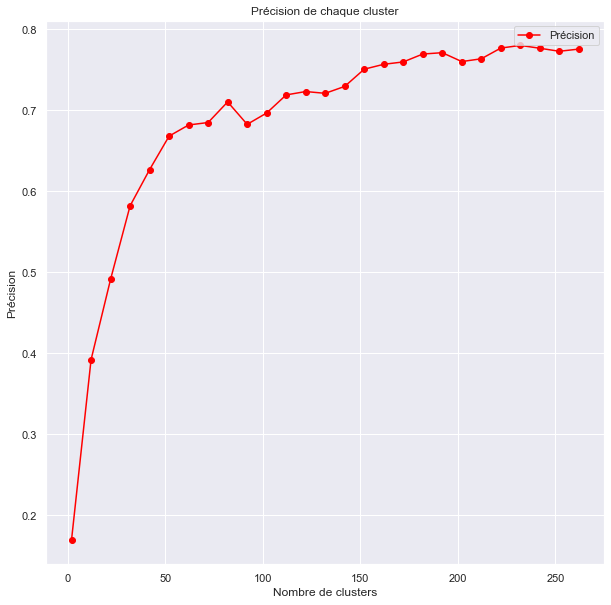

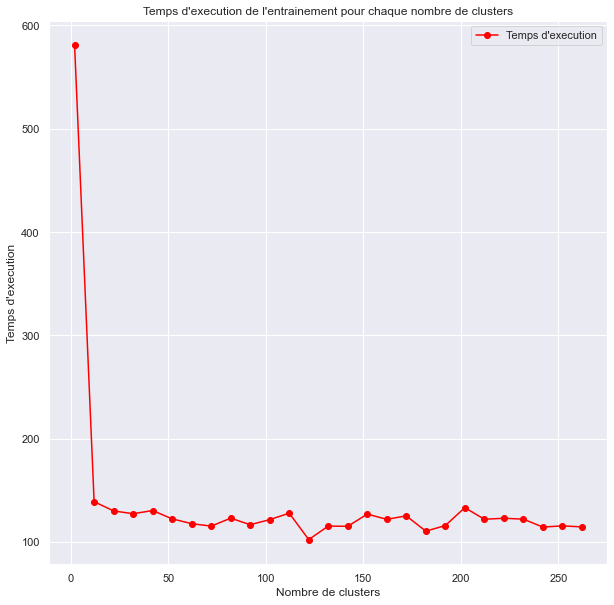

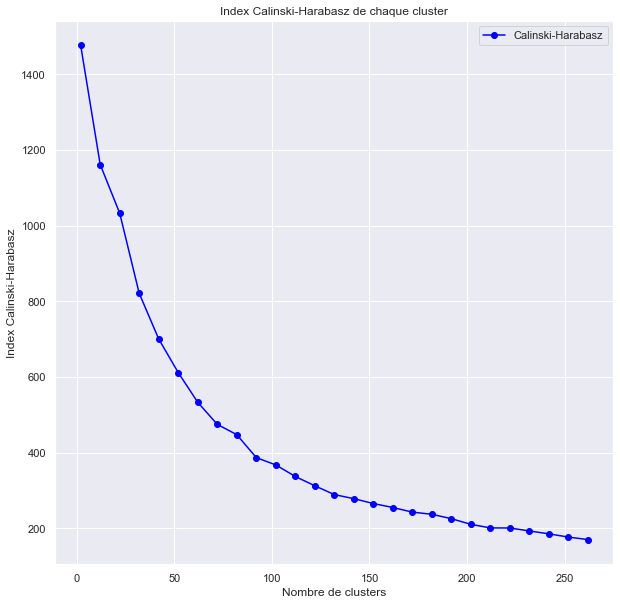

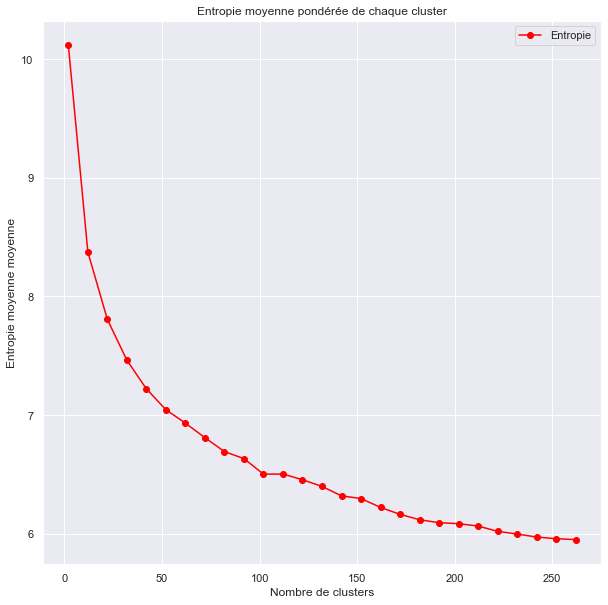

In [23]:
points = range(2, len(inertia_medoids)*10, 10)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, inertia_medoids, c = 'r', label = 'inertie', marker='o')
ax.legend(loc='best')
ax.grid('on')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Coût du modèle (Inertie)')
ax.set_title('Inertie en fonction du nombre de clusters')
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, silhouettes_medoids, label='Silhouettes', c='orange', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score de silhouette moyen')
ax.grid('on')
ax.set_title('Silhouette de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, homogeneite_medoids, label='Homogénéité', c='blue', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Homogénéité')
ax.grid('on')
ax.set_title('Homogénéité de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, precision_medoids, label='Précision', c='red', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Précision')
ax.grid('on')
ax.set_title('Précision de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, times, label="Temps d'execution", c='red', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel("Temps d'execution")
ax.grid('on')
ax.set_title("Temps d'execution de l'entrainement pour chaque nombre de clusters")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, calinski_medoids, label='Calinski-Harabasz', c='blue', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Index Calinski-Harabasz')
ax.grid('on')
ax.set_title('Index Calinski-Harabasz de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, entropie_medoids, label='Entropie', c='red', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Entropie moyenne moyenne')
ax.grid('on')
ax.set_title('Entropie moyenne pondérée de chaque cluster')
plt.show()

In [24]:
max_sil, indexes_sil = maxs_tab(silhouettes_medoids)
max_CH, indexes_CH = maxs_tab(calinski_medoids)
max_en, indexes_en = maxs_tab(entropie_medoids)

print("Silhouette")
print(max_sil)
print(indexes_sil)
print()
print("Indice de Calinski-Harabasz")
print(max_CH)
print(indexes_CH)
print()
print("Entropie Moyenne pondérée")
print(max_en)
print(indexes_en)

Silhouette
[0.027133895, 0.018595472, 0.017003266, 0.013664742, 0.012200186]
[4, 5, 6, 7, 10]

Indice de Calinski-Harabasz
[1476.0129711220977, 1161.1710352126656, 1032.708369071595, 820.6956798897825, 700.1306569496448]
[2, 3, 4, 5, 6]

Entropie Moyenne pondérée
[10.116438412092869, 8.373313926990967, 7.80565648797296, 7.462180720135262, 7.220247851903884]
[2, 3, 4, 5, 6]


### On a trouvé le nombre optimal de clusters. On peut implémenter le modèle K-Medoids avec ce nombre de clusters.

In [25]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
optimal_n_clusters_medoids = 22
with tf.device('/device:GPU:0'):
    start = time.time()

    optimal_model_medoids = KMedoids(n_clusters = optimal_n_clusters_medoids)
    optimal_model_medoids.fit(training_set)

    optimal_prediction_medoids = optimal_model_medoids.predict(training_set)

    end = time.time()
    print("Durée Kmeans pour", optimal_n_clusters_medoids, "clusters:", round((end - start), 2), "s")

Durée Kmeans pour 22 clusters: 125.8 s


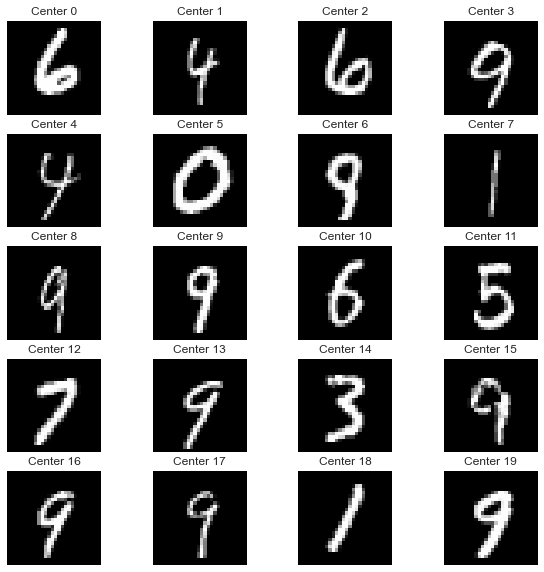

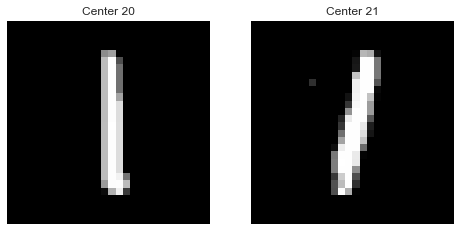

In [26]:
# visualisons les centres de chaque cluster
centroids = optimal_model_medoids.cluster_centers_

centers = []
for i in range(len(centroids)):
    centers.append(centroids[i].reshape(28, 28))


fig, axs = plt.subplots(5, 4, figsize = (10, 10))
plt.gray()
for i, ax in enumerate(axs.flat):
    ax.imshow(centers[i])
    ax.axis('off')
    ax.set_title('Center {}'.format(i))
    
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax[0].imshow(centers[20])
ax[0].axis('off')
ax[0].set_title('Center {}'.format(20))
ax[1].imshow(centers[21])
ax[1].axis('off')
ax[1].set_title('Center {}'.format(21))
plt.show()

Cluster n° 15
taille cluster: 5086


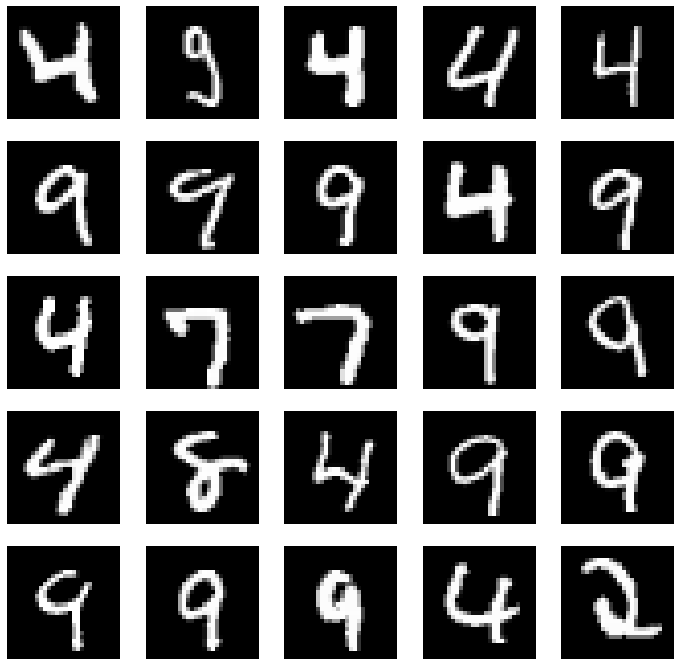


Cluster n° 12
taille cluster: 3025


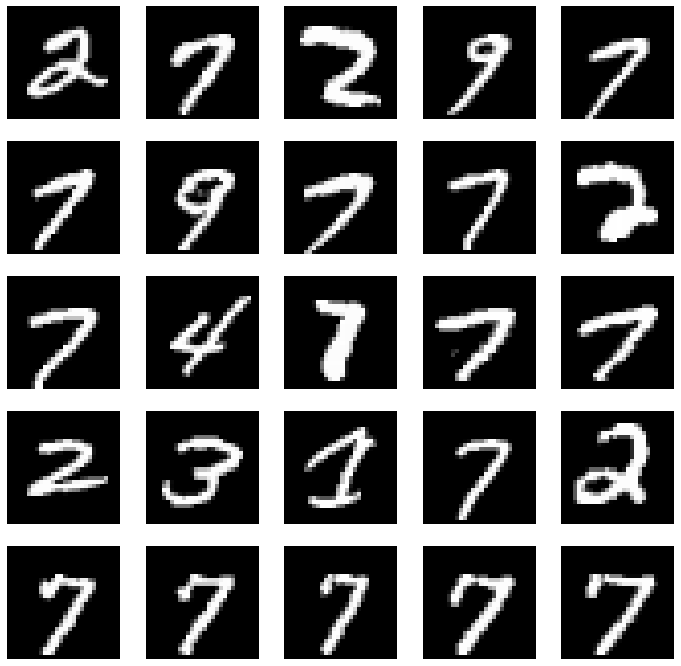

In [27]:
clusters_regardes = np.random.randint(0, optimal_n_clusters_medoids, 2)
for k in clusters_regardes:
    cluster = creer_prediction_set(optimal_prediction_medoids, k)
    print("Cluster n°", k)
    print("taille cluster:", len(cluster))
    fig, axs = plt.subplots(5, 5, figsize = (12, 12))
    plt.gray()
    for i, ax in enumerate(axs.flat):
        ax.imshow(x_train[cluster[i]])
        ax.axis('off')
    plt.show()
    print()

In [28]:
calinski_medoids = calinski_harabasz_score(training_set, optimal_model_medoids.labels_)
print("Indice de Calinski-Harabasz pour", optimal_n_clusters_medoids, "clusters:", calinski_medoids)

entropie_medoids = score_entropy(optimal_model_medoids.labels_, optimal_n_clusters_medoids)
print("Entropie moyenne pour", optimal_n_clusters_medoids, "clusters:", entropie_medoids)

homogen_medoids = homogeneity_score(y_train, optimal_model_medoids.labels_)
print("Homogeneite pour", optimal_n_clusters_medoids, "clusters:", homogen_medoids)

nb_erreurs_medoids = erreurs_totales(optimal_model_medoids.labels_, optimal_n_clusters_medoids)
pourcentage_erreur_medoids = nb_erreurs_medoids/len(training_set)
precision_medoids = 1-pourcentage_erreur_medoids
print("Precision pour", optimal_n_clusters_medoids, "clusters:", precision_medoids)

Indice de Calinski-Harabasz pour 22 clusters: 1032.708369071595
Entropie moyenne pour 22 clusters: 7.80565648797296
Homogeneite pour 22 clusters: 0.40649737103098377
Precision pour 22 clusters: 0.49121666666666663


# Partie 2: on considère maintenant les labels des images

In [29]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Normaliser les données
training_set = x_train.astype(np.float32) / 255.
test_set = x_test.astype(np.float32) / 255.

#chaque image passe d'un format 28x28 à un format 784x1
training_set = training_set.reshape(len(x_train), -1) 
test_set = test_set.reshape(len(y_test), -1)

In [5]:
#avec la fonction creer_prediction_set, on a les images classées dans un meme cluster
#mais le numero du cluster n'est pas necessairement la valeur du label dominant
#cette fonction détermine quel label les images du cluster ont le plus en commun
def determiner_label(prediction):
    labels_found = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0}
    for j in range(len(prediction)):
        i = prediction[j]
        labels_found[str(y_train[i])] += 1
    real_label = 0
    for k in range(10):
        label_multiplicity = labels_found.get(str(k))
        if label_multiplicity > labels_found.get(str(real_label)):
            real_label = k
    return real_label

def erreur_cluster(prediction_set):
    label_set = determiner_label(prediction_set)
    nb_erreurs_label = 0
    for i in range(len(prediction_set)):
        label_image = y_train[prediction_set[i]]
        if label_image != label_set:
            nb_erreurs_label += 1
    return nb_erreurs_label

#cette fonction permet d'associer chaque image du set sur lequel on applique notre algorithme
#au label qu'il lui prédit
def y_predicted(clusters, n_clusters):
    clustering = []
    labelling = []
    for i in range(n_clusters):
        cluster_i = creer_prediction_set(clusters, i)
        label_i = determiner_label(cluster_i)
        clustering.append(cluster_i)
        labelling.append(label_i)
    y_predict = []
    for i in range(len(clusters)):
        k = 0
        while(i not in clustering[k]):
            k += 1
        y_predict.append(labelling[k])
    return y_predict

def erreurs_totales(clusters, n_clusters):
    labels_predicted = y_predicted(clusters, n_clusters)
    nb_erreurs=0
    for i in range(len(clusters)):
        if y_train[i] != labels_predicted[i]:
            nb_erreurs += 1
    return nb_erreurs

In [30]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import accuracy_score

inertia=[]
homogeneite=[]
precision=[]
times=[]

for k in range(2, 263, 5):
    start = time.time()
    
    model_loop = KMeans(n_clusters = k)
    model_loop.fit(training_set)
    
    end = time.time()
    times.append(end-start)
    inertia.append(model_loop.inertia_)
    
    homogen_loop = homogeneity_score(y_train, model_loop.labels_)
    homogeneite.append(homogen_loop)
    
    nb_erreurs_loop = erreurs_totales(model_loop.labels_, k)
    pourcentage_erreur_loop = nb_erreurs_loop/len(training_set)
    precision_k = 1-pourcentage_erreur_loop
    precision.append(precision_k)

In [31]:
points = []
for i in range(2, 263, 5):
    points.append(i)

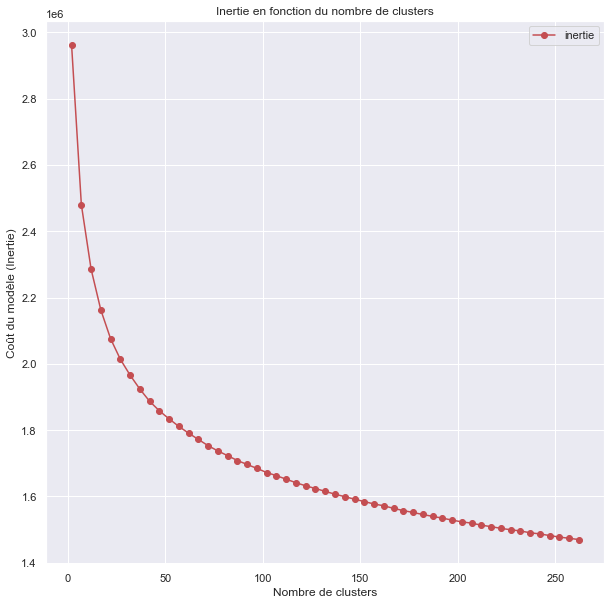

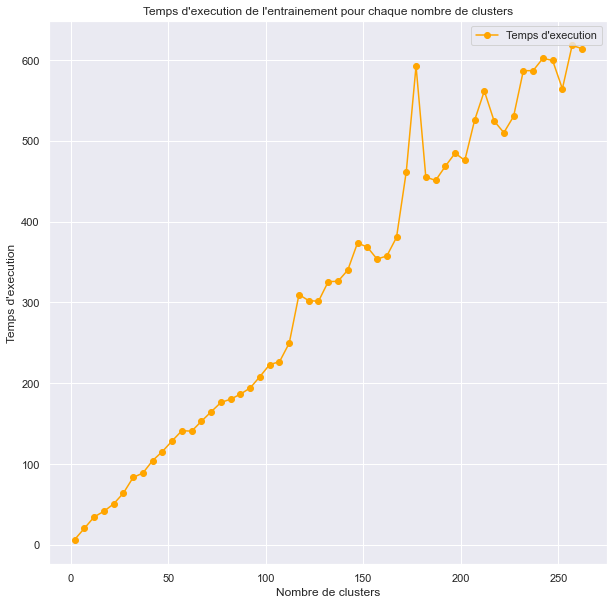

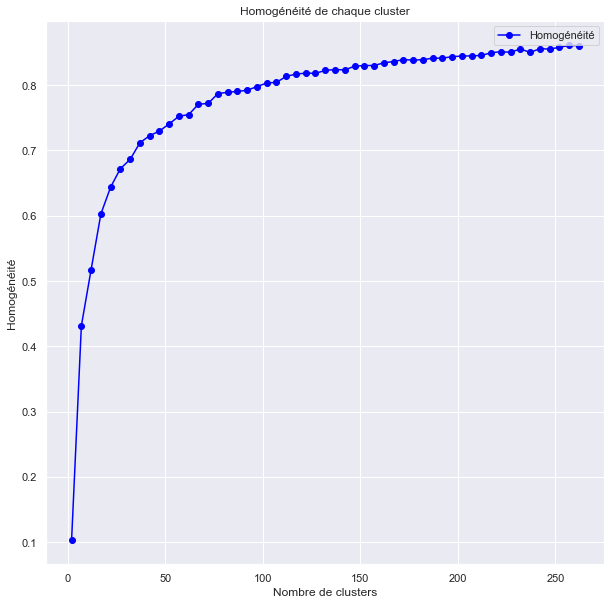

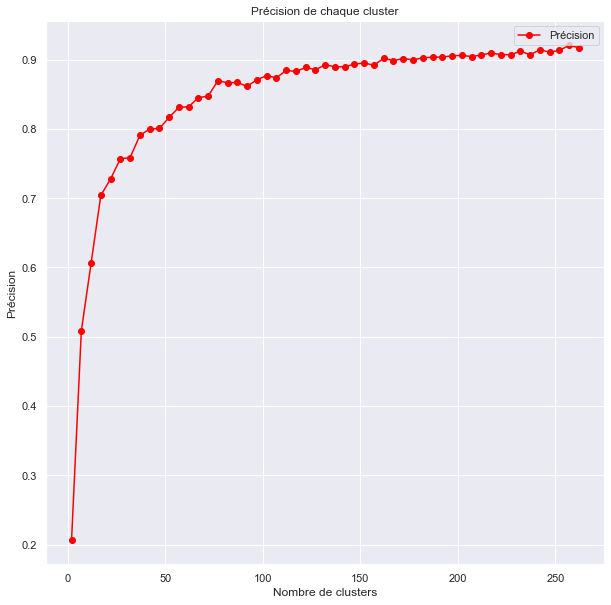

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, inertia, c = 'r', label = 'inertie', marker='o')
ax.legend(loc='best')
ax.grid('on')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Coût du modèle (Inertie)')
ax.set_title('Inertie en fonction du nombre de clusters')
plt.show()
              
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, times, label="Temps d'execution", c='orange', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel("Temps d'execution")
ax.grid('on')
ax.set_title("Temps d'execution de l'entrainement pour chaque nombre de clusters")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, homogeneite, label='Homogénéité', c='blue', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Homogénéité')
ax.grid('on')
ax.set_title('Homogénéité de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, precision, label='Précision', c='red', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Précision')
ax.grid('on')
ax.set_title('Précision de chaque cluster')
plt.show()
